In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import binom

In [18]:
reference = pd.read_csv("ExampleData/CalibrationValues.csv")
ref_mean = reference.groupby("stoichiometry").mean().rate_mVenus.to_list()
ref_sd = reference.groupby("stoichiometry").std().rate_mVenus.to_list()


In [4]:
def calc_P(n, p1, p2):
    """
    # Calculates the probability of detecting pamCherry colocalizing with a detected mVenus cluster.
    # n: oligomeric state;
    # p1: the probability of finding intact mVenus;
    # p2: the probability of detecting a pamCherry when its preceding mVenus is intact;
    #
    """
    def _calc(k):
        return (1 - (1-p2)**k) * (binom(n,k) * p1**k * (1-p1)**(n-k)) / (1-(1-p1)**n)
    k_list = range(1, n+1)
    P_list = list(map(_calc, k_list))
    P_sum = sum(P_list)
    
    return P_list, P_sum

def cp(n_list, p1, p2):
    # This function is just a wrapper to use calc_P with curve_fit
    ret_s = []
    for n in n_list:
        l, s = calc_P(int(n), p1, p2)
        ret_s = np.append(ret_s, s)
        
    return ret_s

def bootstrap(n_samples):
    """"
    # Run a bootstrap resampling over the calibration values
    #
    # n_samples: Number of resamples
    """
    
    return_df = np.array([])
    
    for i in range(0, n_samples):
        rs = reference.sample(frac=1, replace=True) # Resample from the reference distribution
        rm = rs.groupby("stoichiometry").mean().rate_mVenus.to_list() # Calculate mean values per stoichiometry
        popt, pcov = curve_fit(cp, [1,2,3,4], rm, p0=(0.76, 0.17)) # Fit Eq. 6
        return_df = np.append(return_df, popt) # Add the result to the return DataFrame
    return return_df

Mean m: 0.7017520862195186, 95% CI: 0.6135635482851596 - 0.7918171469094911
Mean p: 0.16544024407452243, 95% CI: 0.1506305962988593 - 0.18086215669506378


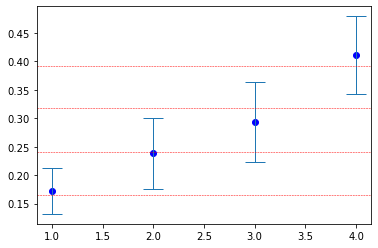

In [30]:
bs = bootstrap(10000).reshape(-1,2) # Run bootstrap
bs_mean = bs.mean(axis=0) # Calculate mean results


print(f"Mean m: {bs_mean[0]}, 95% CI: {np.percentile(bs, 2.5, axis=0)[0]} - {np.percentile(bs, 97.5, axis=0)[0]}")
print(f"Mean p: {bs_mean[1]}, 95% CI: {np.percentile(bs, 2.5, axis=0)[1]} - {np.percentile(bs, 97.5, axis=0)[1]}")



plt.figure()

plt.plot(range(1,5), ref_mean, "bo")
plt.errorbar(range(1,5), ref_mean, yerr=ref_sd, capsize=10, lw=1, fmt="none")
[plt.axhline(calc_P(n, bs_mean[0], bs_mean[1])[1], color="red", ls="--", lw=0.5) for n in range(1,5)]
plt.show()